# MNIST Basics: Neural Networks from Scratch #

In this notebook, we will explore the fundamentals of neural networks by working with the MNIST dataset of handwritten digits. We'll start by visualising the data, then build a simple classifier from scratch — no high-level models yet! Along the way, we’ll learn how to represent images as tensors, compute distances, and gradually move toward a basic neural network to recognize 3s and 7s.

In [1]:
from fastai.vision.all import *
from fastbook import *

/opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <C62FA868-4C49-3B20-AFA6-2F7F59A295B4> /opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. 

### Download Sample of MNIST ###

So let's download a sample of MNIST that contains images of just these digits:

- URLs is a FastAI class that contains links to commonly used datasets.
- untar_data( ) is a FastAI utility function that:
    1. Downloads the dataset from the URL
    2. Extracts it (hence 'untar') and returns a Path object pointing to the local folder where the data is stored.

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

Set the default folder for all file paths in this notebook to be the MNIST sample dataset folder, so I don’t have to type the full path every time.

In [3]:
#hide

# Set the default base folder for all Path objects in this notebook
# This means that later, when we refer to files with relative paths,
# FastAI will look inside the MNIST_SAMPLE folder automatically

Path.BASE_PATH = path

Next we want to take a look in the folder.

ls( ) lists everything in this folder.  However with FastAI, instead of returning a list, it returns an L object.  It acts as a normal list that can be looped, indexed over but also, when you print it, it tells you how many things are in the folder.

In [4]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [5]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the labels (or targets) in this dataset. 

Let's take a look in one of these folders (using sorted to ensure we all get the same order of files):

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png'),Path('train/3/10093.png'),Path('train/3/10097.png'),Path('train/3/10099.png'),Path('train/3/10116.png'),Path('train/3/10125.png'),Path('train/3/10137.png'),Path('train/3/10141.png'),Path('train/3/10144.png'),Path('train/3/10155.png'),Path('train/3/10161.png')...]

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [7]:
# Select the second image file path from the list of '3' images
im3_path = threes[1]

# Open the image at that path using PIL (Python Imaging Library)
im3 = Image.open(im3_path)

# Display the image in the notebook
im3


In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [8]:
# Convert the image `im3` to a NumPy array and extract a small 6x6 patch
# from rows 4 to 9 and columns 4 to 9 (Python slicing excludes the end index)
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

Here's the same thing as a PyTorch tensor:

In [9]:
# Convert the image `im3` to a PyTorch tensor and extract a small 6x6 patch
# from rows 4 to 9 and columns 4 to 9 (Python slicing excludes the end index)
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values

In [10]:
#hide_output
# Convert the image `im3` to a PyTorch tensor
im3_t = tensor(im3)

# Take a subregion of the tensor (rows 4 to 14, columns 4 to 21)
# and convert it into a pandas DataFrame for easier visualization
df = pd.DataFrame(im3_t[4:15, 4:22])

# Style the DataFrame: set the font size very small and apply a grey color gradient
# to visually represent the pixel intensity values
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Here we convert a portion of the image to a DataFrame to better visualize the pixel values.
Darker cells correspond to higher pixel intensity, giving us a clear numeric view of the image region.

So, now we have seen what an image looks like to a computer, let's recall our goal: create a model that can recognize 3s and 7s. 

**How might you go about getting a computer to do that?**

Warning: Stop and Think!: Before you read on, take a moment to think about how a computer might be able to recognize these two different digits.

*Visual differences*

- What shapes or strokes make a 3 different from a 7?
- Look at the curves and lines — which digit has a full curve at the bottom? Which has a straight diagonal line?
  
*Pixel-level clues*

- If a computer looks at the image as a grid of pixels, which pixels might change the most between a 3 and a 7?
- Look at edges and corners — the pixels that form the top bar of a 7, or the loops in a 3, will stand out.
  
*Feature representation*

- How could a computer summarize these differences into simple features (like “curved vs straight”)?
- It could compute averages of pixel intensities, detect lines or curves, or even measure distances to prototype images.
  
*Combining features*

- Once the computer knows several features, how could it combine them to make a prediction?
- It could assign weights to each feature and compute a score, choosing the digit whose features match best.

*Generalisation*

- How would the computer handle handwriting that’s messy or different from training examples?
- The computer needs to learn patterns, not just exact pixels. That’s why neural networks learn flexible representations instead of memorizing images.

## Pixel Similarity ##

How about we find the average pixel value for every pixel of the 3s, then do the same for the 7s? This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

**How Do We Do This?**

Step one for our simple model is to get the average of pixel values for each of our two groups. 

Let's create a tensor containing all of our 3s stacked together. We already know how to create a tensor containing a single image. To create a tensor containing all the images in a directory, we will first use a Python list comprehension to create a plain list of the single image tensors.

Here we load all the training images for digits 3 and 7 and convert them into tensors, preparing the data so it can be used in numerical computations and later fed into a model.

In [11]:
# Open each image file for the digit 7 and convert it into a PyTorch tensor
seven_tensors = [tensor(Image.open(o)) for o in sevens]

# Open each image file for the digit 3 and convert it into a PyTorch tensor
three_tensors = [tensor(Image.open(o)) for o in threes]

# Check how many tensor images we have for each digit
len(three_tensors),len(seven_tensors)

(6131, 6265)

We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's show_image function to display it.

This lets us visually confirm that the tensor data has been loaded correctly by displaying one example of the digit 3.

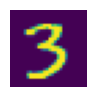

In [12]:
# Display the second image tensor for the digit 3 to visually inspect the data
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a rank-3 tensor. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called stack that we can use for this purpose.

In ELI5 terms:  

You have a big stack of handwritten 3s on paper. Every page is:

- the same size
- made of tiny squares (pixels)
- each square has a darkness value (how much ink is there?)

Now you ask:

“If I look at the top-left square across all the pages, how dark is it on average?”

Then you ask the same question for:

- the next square
- and the next
- and the next…

Until you’ve done it for every pixel position.

In [13]:
# Stack all the 7 image tensors into a single 3D tensor
# Shape: (number_of_images, height, width)
# Convert values to floats and scale pixel intensities from 0–255 to 0–1
stacked_sevens = torch.stack(seven_tensors).float() / 255

# Do the same for all the 3 image tensors
stacked_threes = torch.stack(three_tensors).float() / 255

# Check the shape of the stacked tensor to confirm how the data is organized
stacked_threes.shape


torch.Size([6131, 28, 28])

### Tensors ###

Rank is the number of axes or dimensions in a tensor; shape is the size of each axis of a tensor.  The ELI5 version is to think of it like this:

**Imagine bookshelves 📚**

📖 Rank = how many “levels” of organization

- Rank 0 → a single book
- Rank 1 → a row of books on one shelf
- Rank 2 → a bookshelf with multiple shelves
- Rank 3 → a room full of bookshelves

We can see the rank of our tensor by looking at the length of a tensor's shape - its rank.

This tells us how many axes (dimensions) the tensor has.  For stacked MNIST images, this should be 3: number of images, height, and width:

In [14]:
# Get the number of dimensions (rank) of the stacked_threes tensor
len(stacked_threes.shape)

3

📐 Shape = how many items at each level

shape = (5, 4, 20)

Means:

- 5 bookshelves (rooms don’t matter here)
- each shelf has 4 shelves
- each shelf holds 20 books

In [15]:
stacked_threes.shape

torch.Size([6131, 28, 28])

So the shape of our tensor is:

**6131**
You have 6,131 images
Each image is one handwritten 3

**28**
Each image is 28 pixels tall

**28**
Each image is 28 pixels wide

So altogether this tensor is a stack of 6,131 images, where each image is 28×28 pixels.

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

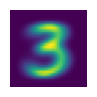

In [16]:
# Compute the average pixel intensity at each pixel position
# across all images of the digit 3
mean3 = stacked_threes.mean(0)

# Display the resulting "average 3" image
show_image(mean3);

**We are basically creating a prototype digit!**

Let's do the same thing for the 7s, but put all the steps together at once to save some time:

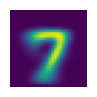

In [17]:
# Compute the average pixel intensity at each pixel position
# across all images of the digit 7
mean7 = stacked_sevens.mean(0)

# Display the resulting "average 7" image
show_image(mean7);


Let's now pick an arbitrary 3 and measure its distance from our "ideal digits."

**How could we do this?**

Think of:

- putting two pictures on top of each other
- checking how different each tiny square (pixel) is
- then adding up all those differences
  
If:

- the picture is very similar → distance is small
- the picture is very different → distance is large

So the smaller distance = more similar.

Let's pick a sample 3:

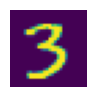

In [18]:
# Select the second image from the stacked_threes tensor
a_3 = stacked_threes[1]

# Display this specific handwritten 3 image
show_image(a_3);

**How can we determine its distance from our ideal 3?**

Here are two main ways data scientists measure distance in this context:

1. Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm.  **ELI5:  The mean absolute difference is like checking every little thermometer (pixel), seeing how far apart the readings are without worrying about sign, and then averaging all those differences to get a single “how different” number.**
     
     

2.  Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm. **ELI5:  Each pixel is like a checkpoint**

   - Compare two images pixel by pixel:
   - Subtract pixels
   - Square the differences → makes everything positive and exaggerates big differences
   - Average over all pixels
   - Take square root → get RMSE
   - Small RMSE → images are similar
   - Large RMSE → images are very different

Let's try both of these now:

In [19]:
# Compute the mean absolute difference (L1 distance) between the selected 3
# and the average (ideal) 3 image
dist_3_abs = (a_3 - mean3).abs().mean()

# Compute the root mean squared error (L2 distance) between the selected 3
# and the average (ideal) 3 image
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()

# Display both distance values for comparison
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

**So what does this tell us?**

0.1114 → L1 distance (mean absolute difference)

- On average, each pixel differs by about 0.11
- Since pixel values are between 0 and 1, this is fairly small
- Meaning: the image looks quite similar to the average 3

0.2021 → L2 distance (RMSE)

- This version penalizes big differences more
- It’s a bit larger because squaring emphasizes pixels that differ a lot
- Still: not huge → the image is reasonably close to the ideal 3

In [20]:
# Compute the mean absolute difference (L1 distance) between the selected 3 and the average (ideal) 7 image
dist_7_abs = (a_3 - mean7).abs().mean()

# Compute the root mean squared error (L2 distance) between the selected 3 and the average (ideal) 7 image
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()

# Display both distance values for comparison
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as loss functions. You'll find these inside torch.nn.functional, which the PyTorch team recommends importing as F (and is available by default under that name in fastai).  These give the same results as our manual calculations, but are more concise and commonly used in practice.

In [21]:
# Compute distances using PyTorch's built-in loss functions:
# - L1 loss (mean absolute difference)
# - Mean squared error (MSE), followed by square root to get RMSE (L2 distance)
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

## NumPy Arrays & PyTorch Tensors ##

NumPy is the most widely used library for scientific and numeric programming in Python. It provides very similar functionality and a very similar API to that provided by PyTorch; however, **it does not support using the GPU or calculating gradients*, which are both critical for deep learning. Therefore, we will generally use PyTorch tensors instead of NumPy arrays, where possible.

**But what are arrays and tensors, and why should you care?**

Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C. In fact, NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.

**NumPy array = very flexible table**

A NumPy array is like a table (or a stack of tables) where:

- Everything is in rows and columns (or more dimensions)
- All items are the same type (like all numbers)

But NumPy is flexible:

- You can even put tables inside tables
- Some inner tables can be different sizes

That’s called a jagged array.

*Example idea:*

- Row 1 has 3 numbers
- Row 2 has 5 numbers
- Row 3 has 2 numbers

NumPy allows that (if you’re careful).  When NumPy stores simple numbers (ints or floats), it packs them very tightly in memory, like a super-organized filing cabinet.  That’s why NumPy is fast — it uses highly optimized C code behind the scenes.

**PyTorch tensor = strict, neat table**

A PyTorch tensor is almost the same idea, but stricter:

- It must be a perfect rectangle
- Every row has the same length
- Every layer has the same shape
- All values must be the same basic numeric type
- No jagged edges allowed 

Think:
✔️ 28×28 images stacked neatly
❌ rows with different lengths

Because everything is so regular:

- PyTorch can do automatic differentiation
- PyTorch can run on GPUs
- Math becomes easier and faster for neural networks

The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but PyTorch tensors have additional capabilities. One major capability is that these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster (given lots of values to work on). In addition, PyTorch can automatically calculate derivatives of these operations, including combinations of operations. As you'll see, it would be impossible to do deep learning in practice without this capability.

### How to use Array/Tensor APIs

Perhaps the most important new coding skill for a Python programmer to learn is how to effectively use the array/tensor APIs

### Creating & Displaying Arrays / Tensors ###

To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to array() or tensor():

In [22]:
# Create a Python list of lists (2D structure)
data = [[1, 2, 3], [4, 5, 6]]

# Convert the Python list into a NumPy array
arr = array(data)

# Convert the Python list into a tensor (e.g. PyTorch tensor)
tns = tensor(data)

In [23]:
arr  # NumPy array: displays the contents of the array in a notebook cell

array([[1, 2, 3],
       [4, 5, 6]])

In [24]:
tns  # PyTorch tensor: displays the tensor values in the notebook

tensor([[1, 2, 3],
        [4, 5, 6]])

All the operations that follow are shown on tensors, but the syntax and results for NumPy arrays is identical.

In [25]:
tns[1]  # Selects the second row of the tensor (indexing starts at 0)

tensor([4, 5, 6])

Or a column, by using : to indicate all of the first axis (we sometimes refer to the dimensions of tensors/arrays as axes):

In [26]:
tns[:, 1]  # Selects the second column of the tensor (all rows, column index 1)

tensor([2, 5])

You can combine these with Python slice syntax ([start:end] with end being excluded) to select part of a row or column:

In [27]:
tns[1, 1:3]  # Returns tensor([5, 6]) — slice of the second row

tensor([5, 6])

And you can use the standard operators such as +, -, *, /:

In [28]:
tns + 1  # Adds 1 to every element in the tensor (element-wise operation)

tensor([[2, 3, 4],
        [5, 6, 7]])

Tensors have a type:

In [29]:
tns.type()

'torch.LongTensor'

And will automatically change type as needed, for example from int to float:

In [30]:
tns * 1.5  # Multiplies every element in the tensor by 1.5 (element-wise)

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

So, is our baseline model any good? To quantify this, we must define a metric.

## Computing Metrics Using Broadcasting ##

A metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is. For instance, we could use either of the functions we saw in the previous section, mean squared error, or mean absolute error, and take the average of them over the whole dataset. However, neither of these are numbers that are very understandable to most people; in practice, we normally use accuracy as the metric for classification models.

We want to calculate our metric over a validation set. This is so that we don't inadvertently overfit—that is, train a model to work well only on our training data. This is not really a risk with the pixel similarity model we're using here as a first try, since it has no trained components, but we'll use a validation set anyway to follow normal practices and to be ready for our second try later.

To get a validation set we need to remove some of the data from training entirely, so it is not seen by the model at all. As it turns out, the creators of the MNIST dataset have already done this for us. There was a whole separate directory called valid. That's what this directory is for!

So to start with, let's create tensors for our 3s and 7s from that directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

In [31]:
# Load all images of the digit '3' from the validation folder, convert them to tensors, 
# and stack them into a single 4D tensor (number of images, height, width, channels)
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])

# Convert the stacked tensor to float and normalize pixel values to range [0,1]
valid_3_tens = valid_3_tens.float()/255

# Load all images of the digit '7' from the validation folder, convert them to tensors, 
# and stack them into a single 4D tensor
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])

# Convert the stacked tensor to float and normalize pixel values to range [0,1]
valid_7_tens = valid_7_tens.float()/255

# Check the shapes of the resulting tensors for '3' and '7'
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

- This code loads all images of digits 3 and 7 from the validation dataset.
- Converts them into PyTorch tensors.
- Normalises pixel values to the [0,1] range.
- Returns the shape of each tensor, which will be (number_of_images, height, width) if grayscale.

Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.

We ultimately want to write a function, is_3, that will decide if an arbitrary image is a 3 or a 7. It will do this by deciding which of our two "ideal digits" this arbitrary image is closer to. For that we need to define a notion of distance—that is, a function that calculates the distance between two images.

We can write a simple function that calculates the mean absolute error using an expression very similar to the one we wrote in the last section:

In [32]:
# Define a function to compute the "distance" between two MNIST images/tensors
# a and b are tensors representing images (or batches of images)
# The function computes the mean absolute difference per pixel across the last two dimensions (height and width)
def mnist_distance(a, b): 
    return (a - b).abs().mean((-1, -2))

# Compute the distance between a specific image a_3 and the mean image of all 3s (mean3)
mnist_distance(a_3, mean3)

tensor(0.1114)

This function measures how similar two MNIST images are, with smaller values meaning more similar:

- (a - b) → subtracts the pixel values of b from a.
- .abs() → takes the absolute value of the difference (so negative differences don’t cancel out positives).
- .mean((-1,-2)) → averages over the last two dimensions, which are the height and width of the image, giving a single number representing the "average pixel difference."

tensor(0.1114)

This is the same value we previously calculated for the distance between these two images, the ideal 3 mean3 and the arbitrary sample 3 a_3, which are both single-image tensors with a shape of [28,28].

But in order to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for every image in the validation set. How do we do that calculation?

Something very interesting happens when we take this exact same distance function, designed for comparing two single images, but pass in as an argument valid_3_tens, the tensor that represents the 3s validation set:

In [34]:
# Compute the distance between each image in the validation set of 3s (valid_3_tens)
# and the mean image of all 3s (mean3) using the mnist_distance function.
valid_3_dist = mnist_distance(valid_3_tens, mean3)

# Display the resulting distances and their shape.
# valid_3_dist is a 1D tensor of length equal to the number of images (here, 1010),
# where each entry is the average pixel difference between an image and mean3.
valid_3_dist, valid_3_dist.shape


(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

PyTorch uses broadcasting when shapes don’t exactly match.
valid_3_tens has shape (1010, 28, 28)
mean3 has shape (28, 28)
When you do valid_3_tens - mean3, PyTorch automatically “stretches” mean3 across the batch dimension: it acts like you subtracted mean3 from each of the 1010 images individually.
Think of it like copying mean3 1010 times “behind the scenes” without actually using more memory. 

But what does that mean in plain English?  Lets use a simple analogy:

- Imagine 1010 pancakes stacked.
- You have one special pancake (mean3).
- You lay that pancake on top of each pancake in the stack.
- For each pancake, measure how different it is from the top pancake.
- You get a list of 1010 difference scores.

mean3 isn’t just a random pancake. It’s the average of all the 3s in the training set.  Comparing each validation image to this average lets us measure how typical or unusual each 3 is.  Using a random 3 would work, but it would be biased—your “distance” would depend too much on the quirks of that one image. Using the average makes it stable and representative.

The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use broadcasting. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.  PyTorch basically knows to loop over 1010 images in the stack.

**Broadcasting**

Lets keep this simple...

We have two tensors:

tensor([1,2,3])     → shape (3)

tensor(1)           → shape ()

One is a list of 3 numbers.
One is just a single number.

PyTorch says:
“Oh, you want to add 1 to every number in the list.”

So it pretends the 1 is actually:
tensor([1,1,1])

Now both tensors are shape (3). That pretending step is broadcasting.

In [35]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

We are calculating the difference between our "ideal 3" and each of the 1,010 3s in the validation set, for each of 28×28 images, resulting in the shape [1010,28,28].

There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity but also for performance:

PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't actually allocate any additional memory
It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).
This is true of all broadcasting and elementwise operations and functions done in PyTorch. It's the most important technique for you to know to create efficient PyTorch code.